# Spatial averaging over ground
This notebook analyses plane wave exposures for various frequencies, E/H polarisations, ground types and angles of incidence

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 15/11/2023

+ FEKO data provided by Danie Ludick
+ This notebook uses the `RFcalcs_v01` module
+ RF exposure is from a plane wave:
  + E-field level of incident plane wave is **100 V/m peak** (70.71 V/m rms, 13.2626 W/m²)
  + Separate runs for:
    + **TM**: Transverse magnetic polarisation with H-field horizontal (Epol)
    + **TE**: Transverse electric polarisation with E-field horizontal (Hpol)
  + The angle of the k-vector wrt the normal from the ground plane is adjusted from **0° to 90°** in 1° increments.
    + an angle of 0° represents the plane wave propagating from above the phantom, normal to ground
    + an angle of 90° represents the plane wave propagating to the front of the phantom, parallel to the ground 
+ Modelled frequencies: **30, 60, 100, 300, 600, 1000, 3000** MHz
+ The FEKO phantom
  + uses the *updated* (**trial 2**) tissue dielectric values
  + faces towards the direction of propagation of the plane wave
  + is raised **10mm above the ground** to simulate wearing footwear
+ Runs are performed for both a **PEC ground** and a **realistic ground ($\epsilon_r$=10, $\sigma$=0.001)**
+ Spatial averaging is conducted over 1.6m and includes the following schemes:
  + Point spatial estimate at z = 1.5m above ground
  + [Simple averaging](https://2fc.gitbook.io/spatial-avg-wg/methodology/numerical-approaches-for-spatial-averaging#traditional-simple-average-approach)
  + [Riemman Sum](https://2fc.gitbook.io/spatial-avg-wg/methodology/numerical-approaches-for-spatial-averaging#riemann-sum-mid-point-rule)
  + [Simpsons 1/3 Rule](https://2fc.gitbook.io/spatial-avg-wg/methodology/numerical-approaches-for-spatial-averaging#simpsons-one-third-rule)
  + [Simpsons 3/8 Rule](https://2fc.gitbook.io/spatial-avg-wg/methodology/numerical-approaches-for-spatial-averaging#simpsons-three-eighths-rule) 
  + [Gaussian Legendre Quadrature](https://pomax.github.io/bezierinfo/legendre-gauss.htmlhttps://pomax.github.io/bezierinfo/legendre-gauss.html)
+ The 1.6m 121-point scheme using Gaussian Legendre Quadrature is deemed the 'near-perfect' solution of the spatial average
+ E & H levels are only recorded along a single vertical line, ranging from z = 0 to 2.8 m in increments of 0.002 m. This fine increment allows us to adequately capture the standing wave patterns at 3000 MHz. 

**TM plane wave exposures (Epol)** (*k-vector shown blue, E-vector shown red*)
<img src="../antennas/pw_gnd/PEC_Epol/human_with_plane_wave_loop_PEC_ground.png" alt="Hpol plane wave exposures" />

**TE plane wave exposures (Hpol)**  (*k-vector shown blue, E-vector shown red*)
<img src="../antennas/pw_gnd/PEC_Hpol/PlaneWave_Hpol_illustration.png" alt="Hpol plane wave exposures" />


## Load necessary python modules

In [1]:
import csv
from zipfile import ZipFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import altair as alt
from scipy import interpolate
from scipy import integrate
from collections.abc import Iterable
import textwrap as tr
import pandas as pd
from RFcalcs_v01 import *
pd.set_option('display.max_rows', 180)
from pprint import pprint
import seaborn as sns

# Set folder locations for antenna, plots and outputs
%cd -0
%cd ../
DATADIR = './antennas/pw_gnd/'
PLOTDIR = './antennas/pw_gnd/plots/'
OUTDIR = './antennas/pw_gnd/outputs/'

# Disable cell warnings (for seaborn warnings)
# import warnings
# warnings.filterwarnings('ignore')

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks
C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg


## Set modelling parameters

In [2]:
Z0 = 376.730313668           # free space impedance
ε0 = 8.854187817620389e-12   # permittivity of free space
µ0 = 1.2566370614359173e-06  # permeability of free space
π = np.pi
E0 = 100                     # incident plane wave E-field peak level (V/m)
S0 = 0.5 * E0**2 / Z0        # incident plane wave S level (W/m²)
FREQ = [30, 60, 100, 300, 600, 1000, 3000]        # Exposure frequencies (MHz)
THETA = list(range(0,91,1))                       # angles of plane wave incidence (degrees)
Z = list(np.linspace(0.001,2.801,1401).round(8))  # z height of assessment points (m)
POL = ['TM','TE']        # Polarisation states of plane wave
GND = ['PEC','RealGnd']  # ground types
L = 1.6                  # spatial averaging length

## Get FEKO E & H data → S

In [3]:
# Function to read zipped FEKO .efe or .hfe files
def read_EH(gnd,pol,fileType):
    '''Read in a zipped .efe or .hfe FEKO file and convert to dataframe
    INPUTS:
      gnd = ground ('PEC' or 'dirt')
      pol = plane wave polarisation ('TM' or 'TE')
      filetype = FEKO filetype ('.efe' or .hfe')
    '''
    
    # Read in zipped data file and convert to a list of strings
    file = f'PlaneWave_{gnd}_{pol}{fileType}'
    zipfile = f'{DATADIR}{gnd}_{pol}/{file}.zip'
    print(zipfile)
    with ZipFile(zipfile,'r') as zf:
        with zf.open(file) as f:
            text = f.readlines()
            text = [row.decode('ASCII').strip() for row in text]
            text = [row.split() for row in text if row[:15] == '0.00000000E+000']
    
    # Create dataframe from text list
    xyz = ['x','y','z']
    Enames = ['Exr','Exi','Eyr','Eyi','Ezr','Ezi']
    Hnames = ['Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
    fieldnames = Enames if fileType=='.efe' else Hnames        
    df = pd.DataFrame(text, columns=xyz+fieldnames).astype(float)
    print(f'{gnd=}, {pol=}, {fileType=}, {len(df)=}')
    
    # Add fMHz column
    n = len(THETA) * len(Z)
    fMHz_col = [30]*n + [60]*n + [100]*n + [300]*n + [600]*n + [1000]*n + [3000]*n
    df['fMHz'] = fMHz_col
    
    # Add theta column
    theta_stub = np.repeat(THETA, len(Z))
    theta_col = np.tile(theta_stub, len(FREQ))
    df['theta'] = theta_col

    # Add gnd and pol columns
    df['gnd'] = gnd
    df['pol'] = pol

    # Rearrange columns
    cols = ['gnd','pol','fMHz','theta','z'] + fieldnames       
    df = df[cols]

    # Set data types
    convert_dict = {'fMHz':int, 'theta': int}
    df = df.astype(convert_dict)
    
    # Drop theta = 90 values since there was no exposure
    # df = df[df.theta != 90]
    
    return df

In [4]:
# Get S data for each ground and polarisation
S = pd.DataFrame()
for gnd in GND:
    for pol in POL:
        # Get E and H FEKO data files
        Edat = read_EH(gnd,pol,'.efe')
        Hdat = read_EH(gnd,pol,'.hfe')

        # Calculate SE, SH, Smax
        SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
        SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377

        # Create trial dataframe
        Strial = pd.DataFrame(dict(gnd=Edat.gnd,pol=Edat.pol,fMHz=Edat.fMHz,theta=Edat.theta,
                                   z=Edat.z,S0=S0,SE=SE,SH=SH)).reset_index(drop=True)

        # Append Strial to S dataframe
        S = Strial if len(S)==0 else pd.concat([S,Strial],ignore_index=True)

./antennas/pw_gnd/PEC_TM/PlaneWave_PEC_TM.efe.zip
gnd='PEC', pol='TM', fileType='.efe', len(df)=892437
./antennas/pw_gnd/PEC_TM/PlaneWave_PEC_TM.hfe.zip
gnd='PEC', pol='TM', fileType='.hfe', len(df)=892437
./antennas/pw_gnd/PEC_TE/PlaneWave_PEC_TE.efe.zip
gnd='PEC', pol='TE', fileType='.efe', len(df)=892437
./antennas/pw_gnd/PEC_TE/PlaneWave_PEC_TE.hfe.zip
gnd='PEC', pol='TE', fileType='.hfe', len(df)=892437
./antennas/pw_gnd/RealGnd_TM/PlaneWave_RealGnd_TM.efe.zip
gnd='RealGnd', pol='TM', fileType='.efe', len(df)=892437
./antennas/pw_gnd/RealGnd_TM/PlaneWave_RealGnd_TM.hfe.zip
gnd='RealGnd', pol='TM', fileType='.hfe', len(df)=892437
./antennas/pw_gnd/RealGnd_TE/PlaneWave_RealGnd_TE.efe.zip
gnd='RealGnd', pol='TE', fileType='.efe', len(df)=892437
./antennas/pw_gnd/RealGnd_TE/PlaneWave_RealGnd_TE.hfe.zip
gnd='RealGnd', pol='TE', fileType='.hfe', len(df)=892437


In [5]:
mask = (S.gnd=='PEC') & (S.pol=='TM') & (S.theta==90) & \
       (S.fMHz==1000) & (S.z <= 2)
S[mask]

,gnd,pol,fMHz,theta,z,S0,SE,SH
763545,PEC,TM,1000,90,0.001,13.272094,53.050398,53.126379
763546,PEC,TM,1000,90,0.003,13.272094,53.050398,53.126379
763547,PEC,TM,1000,90,0.005,13.272094,53.050398,53.126379
763548,PEC,TM,1000,90,0.007,13.272094,53.050398,53.126379
763549,PEC,TM,1000,90,0.009,13.272094,53.050398,53.126379
...,...,...,...,...,...,...,...,...
764540,PEC,TM,1000,90,1.991,13.272094,53.050398,53.126379
764541,PEC,TM,1000,90,1.993,13.272094,53.050398,53.126379
764542,PEC,TM,1000,90,1.995,13.272094,53.050398,53.126379
764543,PEC,TM,1000,90,1.997,13.272094,53.050398,53.126379


## Get SAR data → SAR

In [6]:
SAR = pd.DataFrame()
for gnd in GND:
    for pol in POL:
        for fMHz in FREQ:
            SARfile = f'wbaSAR_{fMHz}MHz.dat'
            folder = DATADIR + f'{gnd}_{pol}/'
            print(folder+SARfile)
            df = pd.read_csv(folder+SARfile,skiprows=2,names=('theta','SARwb')
                             ,sep='\t',index_col=False,dtype={'theta':int,'SARwb':float})
            df['gnd'] = gnd
            df['pol'] = pol
            df['fMHz'] = fMHz
            SAR = df if len(SAR)==0 else pd.concat([SAR,df],ignore_index=True)
SAR = SAR[['gnd','pol','fMHz','theta','SARwb']]

# drop theta = 90 values
SAR = SAR[SAR.theta != 90]
SAR

./antennas/pw_gnd/PEC_TM/wbaSAR_30MHz.dat
./antennas/pw_gnd/PEC_TM/wbaSAR_60MHz.dat
./antennas/pw_gnd/PEC_TM/wbaSAR_100MHz.dat
./antennas/pw_gnd/PEC_TM/wbaSAR_300MHz.dat
./antennas/pw_gnd/PEC_TM/wbaSAR_600MHz.dat
./antennas/pw_gnd/PEC_TM/wbaSAR_1000MHz.dat
./antennas/pw_gnd/PEC_TM/wbaSAR_3000MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_30MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_60MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_100MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_300MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_600MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_1000MHz.dat
./antennas/pw_gnd/PEC_TE/wbaSAR_3000MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_30MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_60MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_100MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_300MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_600MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_1000MHz.dat
./antennas/pw_gnd/RealGnd_TM/wbaSAR_3000MHz.dat
./antennas/pw_gnd/RealGnd_TE/wbaSAR_30MHz.dat
./antennas/pw_gnd/RealG

,gnd,pol,fMHz,theta,SARwb
0,PEC,TM,30,0,0.001374
1,PEC,TM,30,1,0.001496
2,PEC,TM,30,2,0.001860
3,PEC,TM,30,3,0.002469
4,PEC,TM,30,4,0.003320
...,...,...,...,...,...
2542,RealGnd,TE,3000,85,0.150729
2543,RealGnd,TE,3000,86,0.148404
2544,RealGnd,TE,3000,87,0.138123
2545,RealGnd,TE,3000,88,0.173953


## Spatial averages

### spatial averaging function
Calculate the z points and weights for various averaging schemes over length L with points referenced to z=0 at ground

INPUTS:
+ n = No. of GQR points
+ L = integration length (m), or z point height for point spatial scheme
+ kind = type of spatial averaging scheme ('ps','simple', 'S13', 'S38', 'GQR')

OUTPUTS:
+ z = integration points along L relative to z=0 at ground (m)
+ w = weights

In [7]:
def sagnd(kind:str, n:int, L:float):
    '''Calculate z-points and weights for various spatial averaging
       schemes over ground
       INPUTS:
         kind = spatial averaging scheme ('ps','simple', 'S13', 'S38', 'GQR')
         n = number of spatial averaging points
         L = spatial averaging length, or height of point for 'ps' case
       OUTPUTS:
         z = np array of spatial avg assessment point heights (z=0 at ground level)
         w = np array of assessment point weights
    '''
    kinds = ('ps','RS','simple','S13','S38','GQR')
    assert kind in kinds, f'kind {kind} must be one of {kinds}'
    match kind:          
        case 'ps':
            # point spatial
            z = np.array([L])
            w = np.array([1])
          
        case 'simple':
            # Simple average
            assert (n >= 2), f"n ({n}) must be >= 2"
            z = np.linspace(0,L,n)
            w = np.ones(n) / n
            
        case 'RS':
            # Riemann Sum
            assert (n >= 2), f"n ({n}) must be >= 2"
            z = np.linspace(L/(2*n), L-L/(2*n), n)
            w = np.ones(n) / n            
          
        case 'GQR':
            # Gaussian Legendre Quadrature Rule
            z, w = np.polynomial.legendre.leggauss(n)
            z = (z + 1) * L/2
            w = w / 2
          
        case 'S13':
            # Simpsons 1/3 rule
            assert (n >= 2), f"n ({n}) must be >= 2"
            assert (n%2 == 1), f"n ({n}) must be odd"
            z = np.linspace(0,L,n)
            w = np.ones(n)
            wts = [4,2]*300  # a pop list for the weights
            for i in range(n-2):
                w[i+1] = wts.pop(0)
            w = w / sum(w)
          
        case 'S38':
            # Simpsons 3/8 Rule
            assert (n >= 4), f"n ({n}) must be >= 4"
            assert ((n-1)%3 == 0), f"number of intervals ({n-1}) must be odd"
            z = np.linspace(0,L,n)
            w = np.ones(n)
            wts = [3,3,2]*300  # a pop list for the weights
            for i in range(n-2):
                w[i+1] = wts.pop(0)
            w = w / sum(w)
    
    return z, w

### Calculate spatial averages → Ssa

In [8]:
Ssa_list = []
for l in make_iterable(L):
    for Si in ['SE','SH']:
        for (gnd,pol,fMHz,theta), g in S.groupby(['gnd','pol','fMHz','theta']):
            f = interpolate.interp1d(g.z.values, g[Si].values, kind='quadratic', fill_value='extrapolate')
            
            # S0 estimate
            n,lps,kind,Sz = 1,0,'S0',S0
            Ssa_list.append([gnd,pol,fMHz,theta,Si,n,lps,kind,Sz])
            
            # Point spatial estimate at 1.5m
            n,lps,kind,Sz = 1,0,'1.5m',f(1.5)
            Ssa_list.append([gnd,pol,fMHz,theta,Si,n,lps,kind,Sz])
            
            # Spatial average estimates
            for n in [3,5,7,13,19,121]:
                for kind in ('simple','RS','S13','S38','GQR'):
                    # name = f'{gnd}-{pol}pol-{fMHz}MHz-{theta}deg-{Si}-{L}m-{n}-{kind}' 
                    if kind=='S38' and (n-1)%3 != 0:
                        pass
                    else:
                        z, w = sagnd(kind, n, L)
                        Sz = f(z)
                        Ssai = (Sz * w).sum()
                        Ssa_list.append([gnd,pol,fMHz,theta,Si,n,l,kind,Ssai])
                    
Ssa = pd.DataFrame(Ssa_list,columns=('gnd','pol','fMHz','theta','Si','n','L','kind','S'))
Ssa = Ssa.astype({'S':float})

# A few (4) values for H-pol, theta=2, Si=SE and fMHz=3000 are 
# just below zero due to interpolation approximation errors
# Set these values to 1E-6 to avoid dBerr errors
mask = Ssa.S <= 0
Ssa.loc[mask,'S'] = 1E-6
Ssa

,gnd,pol,fMHz,theta,Si,n,L,kind,S
0,PEC,TE,30,0,SE,1,0.0,S0,13.272094
1,PEC,TE,30,0,SE,1,0.0,1.5m,34.754849
2,PEC,TE,30,0,SE,3,1.6,simple,16.726784
3,PEC,TE,30,0,SE,3,1.6,RS,14.377921
4,PEC,TE,30,0,SE,3,1.6,S13,14.527330
...,...,...,...,...,...,...,...,...,...
152875,RealGnd,TM,3000,90,SH,121,1.6,simple,0.000001
152876,RealGnd,TM,3000,90,SH,121,1.6,RS,0.000001
152877,RealGnd,TM,3000,90,SH,121,1.6,S13,0.000001
152878,RealGnd,TM,3000,90,SH,121,1.6,S38,0.000001


## Merge Ssa and SAR data → Sall

In [9]:
Sall = SAR.merge(Ssa,how='outer',on=('gnd','pol','fMHz','theta'))
Sall

,gnd,pol,fMHz,theta,SARwb,Si,n,L,kind,S
0,PEC,TM,30,0,0.001374,SE,1,0.0,S0,13.272094
1,PEC,TM,30,0,0.001374,SE,1,0.0,1.5m,34.754849
2,PEC,TM,30,0,0.001374,SE,3,1.6,simple,16.726784
3,PEC,TM,30,0,0.001374,SE,3,1.6,RS,14.377921
4,PEC,TM,30,0,0.001374,SE,3,1.6,S13,14.527330
...,...,...,...,...,...,...,...,...,...,...
152875,RealGnd,TM,3000,90,NaN,SH,121,1.6,simple,0.000001
152876,RealGnd,TM,3000,90,NaN,SH,121,1.6,RS,0.000001
152877,RealGnd,TM,3000,90,NaN,SH,121,1.6,S13,0.000001
152878,RealGnd,TM,3000,90,NaN,SH,121,1.6,S38,0.000001


In [10]:
# Rename 'RealGnd' to 'Real' in gnd column
Sall.loc[Sall.gnd=='RealGnd','gnd'] = 'real'

## Calculate R, err & errS0 → Sall2
___

$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

___

$err$ is the spatial averaging error

The 121 point GQR spatial averaging scheme is taken as the benchmark for a 'near-perfect' spatial average

$\Large err = \frac{S_{sa}}{S_{max}-1.6m-121-GQR}$

where $S_{max}$ is the larger of $S_E$ and $S_H$

### Get benchmark S values → Sb

In [11]:
def getSb(g):
    '''Get the maximum value of SE & SH for the near-perfect
       spatial average bench mark value using GQR and 121 points'''
    mask = (g.kind=="GQR") & (g.n==121)
    Sb = g.loc[mask,'S'].max()
    return Sb
    
Sb = Sall.groupby(['gnd', 'pol', 'fMHz', 'theta']).apply(getSb).reset_index(name='Sb')
Sb

,gnd,pol,fMHz,theta,Sb
0,PEC,TE,30,0,38.501158
1,PEC,TE,30,1,38.497429
2,PEC,TE,30,2,38.486225
3,PEC,TE,30,3,38.467490
4,PEC,TE,30,4,38.441133
...,...,...,...,...,...
2543,real,TM,3000,86,17.260122
2544,real,TM,3000,87,21.429048
2545,real,TM,3000,88,19.587919
2546,real,TM,3000,89,26.236517


In [12]:
# Test Sb results
gnd = 'PEC'
pol = 'TE'
fMHz = 30
theta = 0
mask = (Sb.gnd==gnd) & (Sb.pol==pol) & \
       (Sb.fMHz==fMHz) & (Sb.theta==theta)
Sb.loc[mask,'Sb'].values[0]  # we take the maximum of SE and SH

38.50115755874572

### Calculate values

In [13]:
Sall2 = pd.DataFrame()
for (gnd,pol,fMHz,theta,Si), df in Sall.groupby(['gnd', 'pol', 'fMHz', 'theta', 'Si']):    
    # Calculate R
    freq = df.fMHz.values[0]
    Slim = Slimit(freq, setting='pub', standard='RPS S-1 WB')
    SARlim = 0.08
    df['Slim'] = Slim
    df['R'] = (df.S/Slim) / (df.SARwb/SARlim)
    
    # Calculate err
    mask = (Sb.gnd==gnd) & (Sb.pol==pol) & \
           (Sb.fMHz==fMHz) & (Sb.theta==theta)
    Sbenchmark = Sb.loc[mask,'Sb'].values[0] 
    df['err'] =  df.S / Sbenchmark
    
    # Append df to Sall2
    Sall2 = df if Sall2.size == 0 else pd.concat([Sall2,df])
    
# Add dBR and dBerr
Sall2['dBR'] = dB(Sall2.R)
Sall2['dBerr'] = dB(Sall2.err)

## Melt S → Sm 

In [14]:
# Melt the S dataframe for S values
Sm = S.melt(id_vars=('gnd','pol','fMHz','theta','z'),
            value_vars=('SE','SH'),
            var_name='S type',value_name='S',
            ignore_index=True)
Sm.head()

# Rename 'RealGnd' to 'Real' in gnd column
Sm.loc[Sm.gnd=='RealGnd','gnd'] = 'real'
Sm.head()

,gnd,pol,fMHz,theta,z,S type,S
0,PEC,TM,30,0,0.001,SE,0.000021
1,PEC,TM,30,0,0.003,SE,0.000189
2,PEC,TM,30,0,0.005,SE,0.000524
3,PEC,TM,30,0,0.007,SE,0.001028
4,PEC,TM,30,0,0.009,SE,0.001699


## Plots

In [15]:
sns.set_theme(style='ticks')

In [21]:
gnd = 'PEC'
pol = 'TM'
freqs = [1000]
theta = 89
Stype = 'SH'
mask = (Sm.gnd==gnd) & (Sm.theta==theta) & (Sm['S type']==Stype) &\
       (Sm.fMHz.isin(freqs)) & (Sm.pol==pol) & (Sm.z <= 2)
Sm.loc[mask,'S'].describe()

count    1000.000000
mean       44.613405
std         7.267218
min        29.437698
25%        38.684048
50%        46.329898
75%        51.365654
max        53.126371
Name: S, dtype: float64

### S vs z (SH & SH)

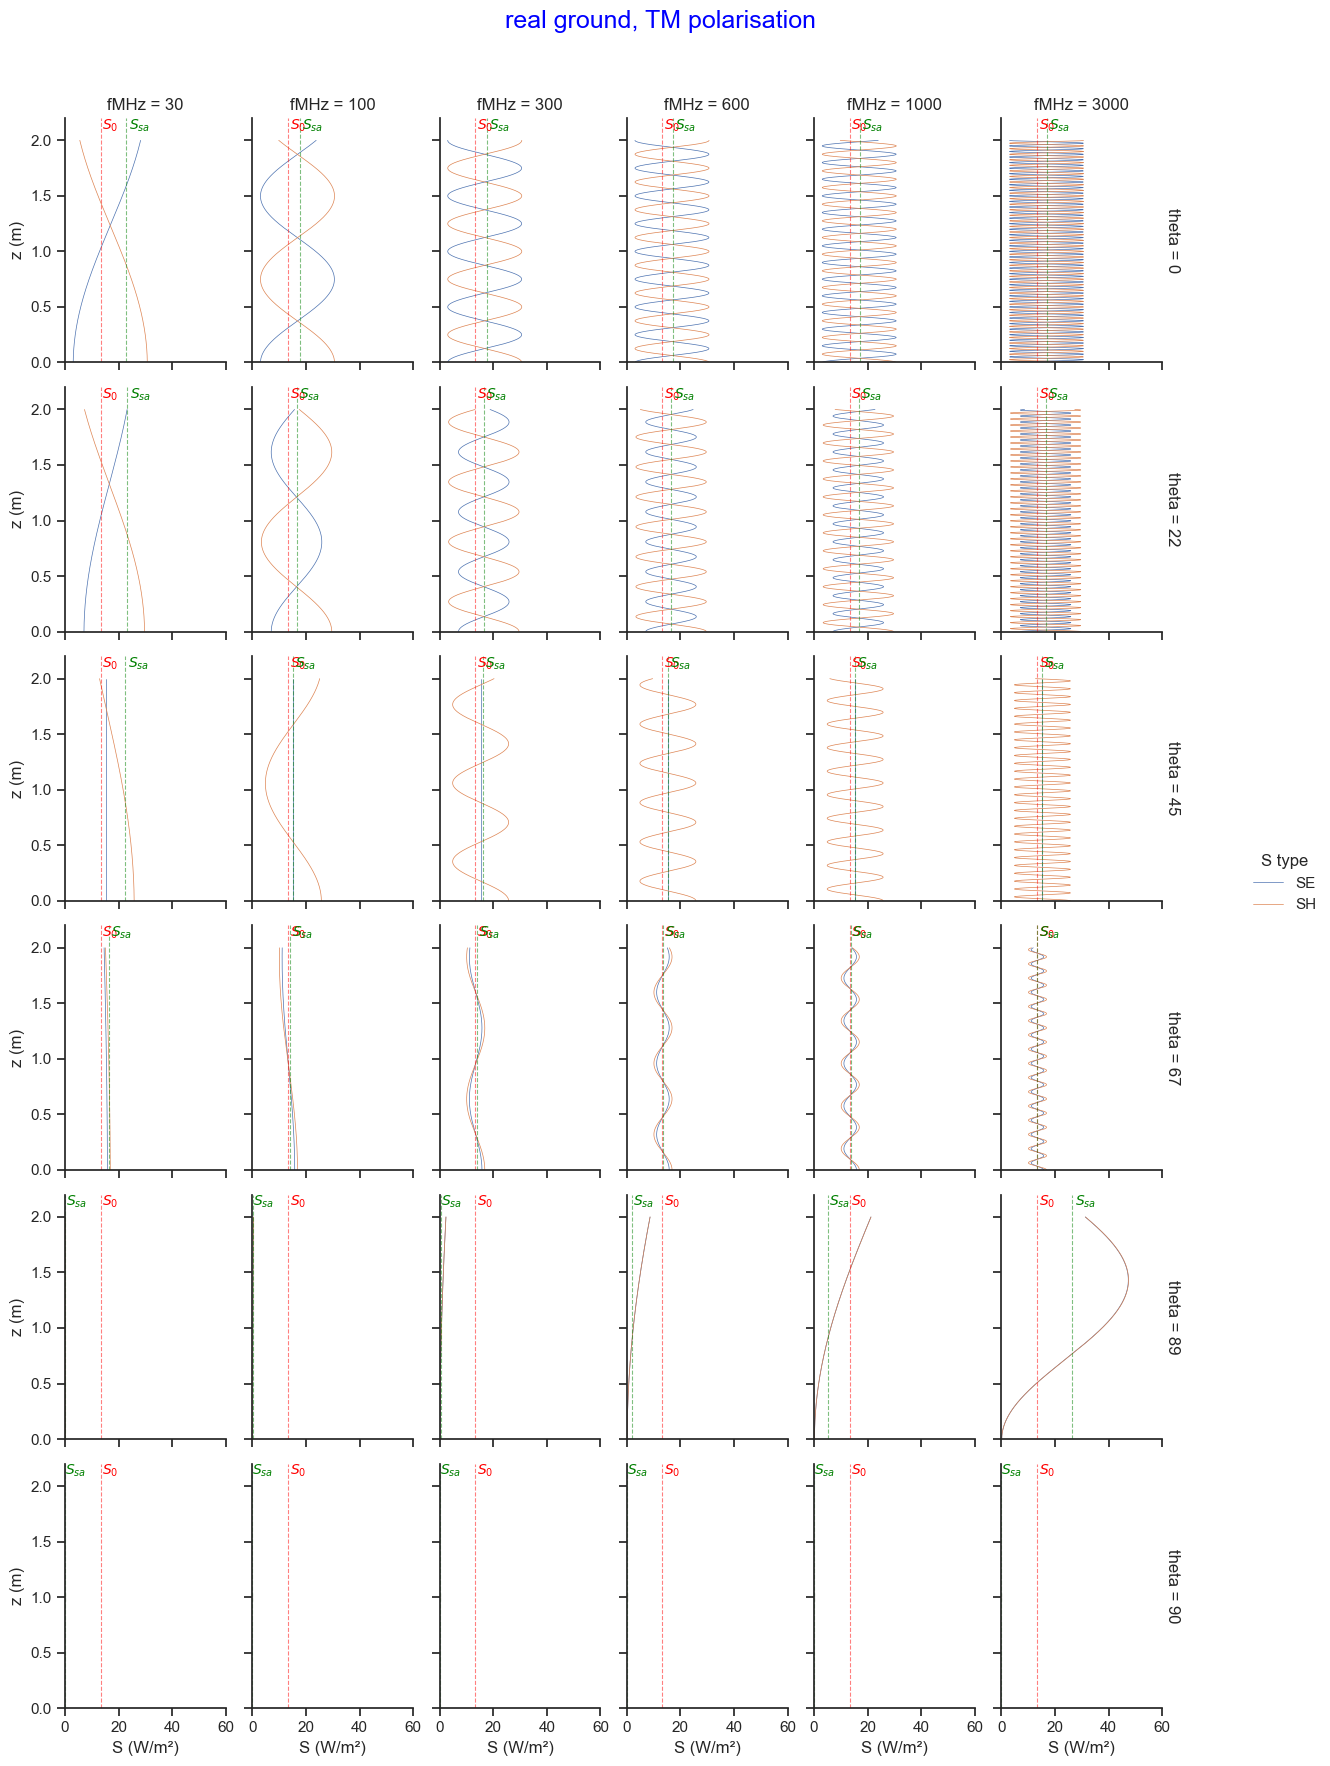

In [22]:
# Compare SE and SH
gnd = 'real'
pol = 'TM'
freqs = [30,100,300,600,1000,3000]
thetas = [0,22,45,67,89,90]
names = [[freq,theta] for theta in thetas for freq in freqs]
mask = (Sm.gnd==gnd) & (Sm.theta.isin(thetas)) & \
       (Sm.fMHz.isin(freqs)) & (Sm.pol==pol) & (Sm.z <= 2)

# Create the plot
p = sns.relplot(
    data=Sm[mask],x="S", y="z",
    row="theta",col="fMHz",hue="S type",
    kind="line", linewidth=0.5,
    height=3, aspect=0.7, sort=False,
    facet_kws={"margin_titles": True}
)
p.refline(x=S0, color='red', lw=0.8,alpha=0.5)
for ax, (freq, theta) in zip(p.fig.axes, names):
    ax.text(S0*1.05, 2.1, "$S_0$",horizontalalignment='left', 
            color='red',fontsize=10)
    mask = (Sb.gnd==gnd) & (Sb.pol==pol) & (Sb.fMHz==freq) & (Sb.theta==theta)
    Sbi = Sb.loc[mask,'Sb'].values[0]
    ax.text(Sbi*1.05,2.1,'$S_{sa}$',fontsize=10,color='green')
    ax.axvline(x=Sbi, color='green', ls='--',lw=0.8,alpha=0.5)

p.set(xlim=(0, 60),ylim=(0,2.2),xlabel='S (W/m²)',ylabel='z (m)')
p.fig.subplots_adjust(top=0.92)
p.fig.suptitle(f'{gnd} ground, {pol} polarisation',color='blue',
             fontsize=18);
for fe in ['png','svg']:
    plt.savefig(PLOTDIR + f'S v z_{gnd}_{pol}.{fe}')

### S vs z (TM & TE)

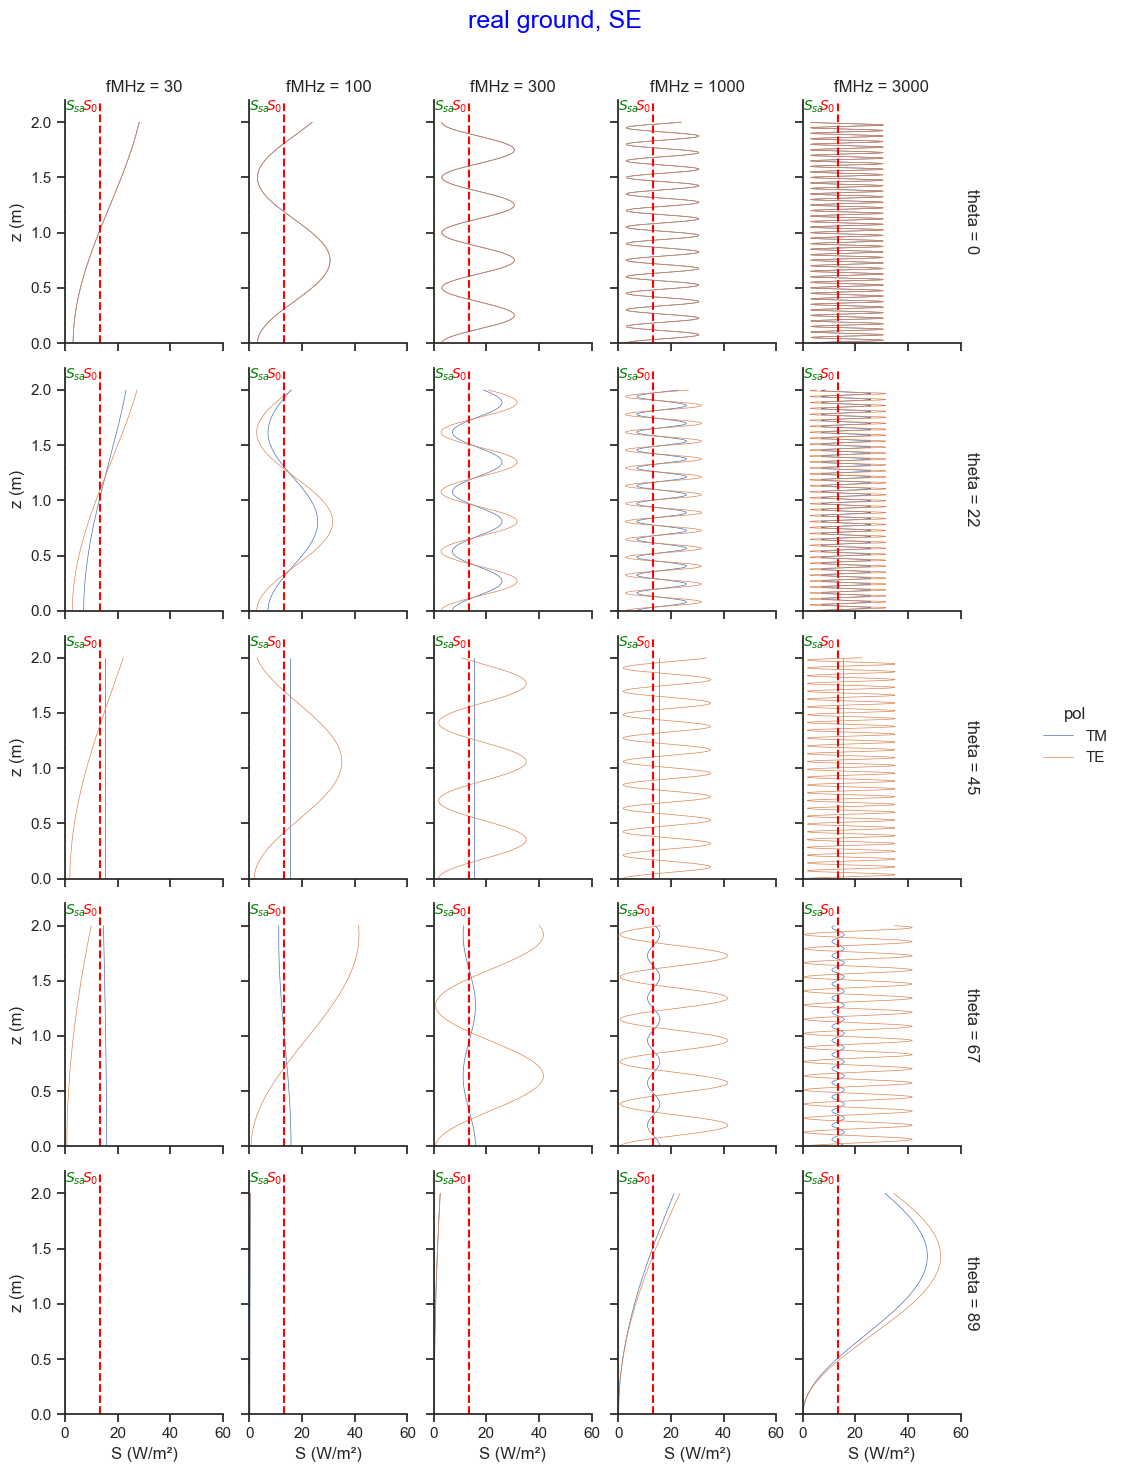

In [23]:
# Compare TM and TE polarisations
gnd = 'real'
Stype = 'SE'
mask = (Sm.gnd==gnd) & (Sm.theta.isin([0,22,45,67,89])) & \
       (Sm.fMHz.isin([30,100,300,1000,3000])) & (Sm['S type']==Stype) & (Sm.z <= 2)

# Plot the lines on two facets
# palette = sns.color_palette("rocket_r")
p = sns.relplot(
    data=Sm[mask],x="S", y="z",
    row="theta",col="fMHz",hue="pol",
    kind="line", linewidth=0.5,
    height=3, aspect=0.7, sort=False,
    facet_kws={"margin_titles": True}
)
p.refline(x=S0, color='red')
for ax in p.fig.axes:
    ax.text(S0*0.95, 2.1, "$S_0$",horizontalalignment='right', 
            color='red',fontsize=10)
    mask = (Sb.gnd==gnd) & (Sb.pol==pol) & (Sb.fMHz==freq) & (Sb.theta==theta)
    Sbi = Sb.loc[mask,'Sb'].values[0]
    ax.text(Sbi*1.05,2.1,'$S_{sa}$',fontsize=10,color='green')
    ax.axvline(x=Sbi, color='green', ls='--',lw=0.8,alpha=0.5)

p.set(xlim=(0, 60),ylim=(0,2.2),xlabel='S (W/m²)',ylabel='z (m)')
p.fig.subplots_adjust(top=0.92)
p.fig.suptitle(f'{gnd} ground, {Stype}',color='blue',
             fontsize=18);
for fe in ['png','svg']:
    plt.savefig(PLOTDIR + f'S v z_{gnd}_{Stype}.{fe}')

### dBR

#### line plots

In [24]:
def dBRvTheta(df, gnd, pol, n):
    # Filter the data 
    mask = (df.gnd==gnd) & (df.pol==pol) & (df.n==n) & (df.fMHz.isin(freqs))

    # Plot the lines on two facets
    p = sns.relplot(
        df[mask],x="theta",y="dBR",col="fMHz",row="kind",hue="Si",
        kind="line",linewidth=0.7,height=3, aspect=0.8,sort=False, 
        facet_kws=dict(margin_titles=True),
    )
    p.map(plt.axhline, y=0, ls='--', c='red')
    p.set(xlim=(0, 90),xlabel=r'$\theta$°',ylabel='dB(R)')
    top = 0.78 if n==1 else 0.90
    p.fig.subplots_adjust(top=top)
    txt = f'point' if n==1 else 'points'
    Rformula = r'$R=\frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}$'
    title = f'dB(R) for {gnd} ground, {pol} polarisation, {n} averaging {txt}\n' + Rformula
    p.fig.suptitle(title,color='blue',fontsize=18)

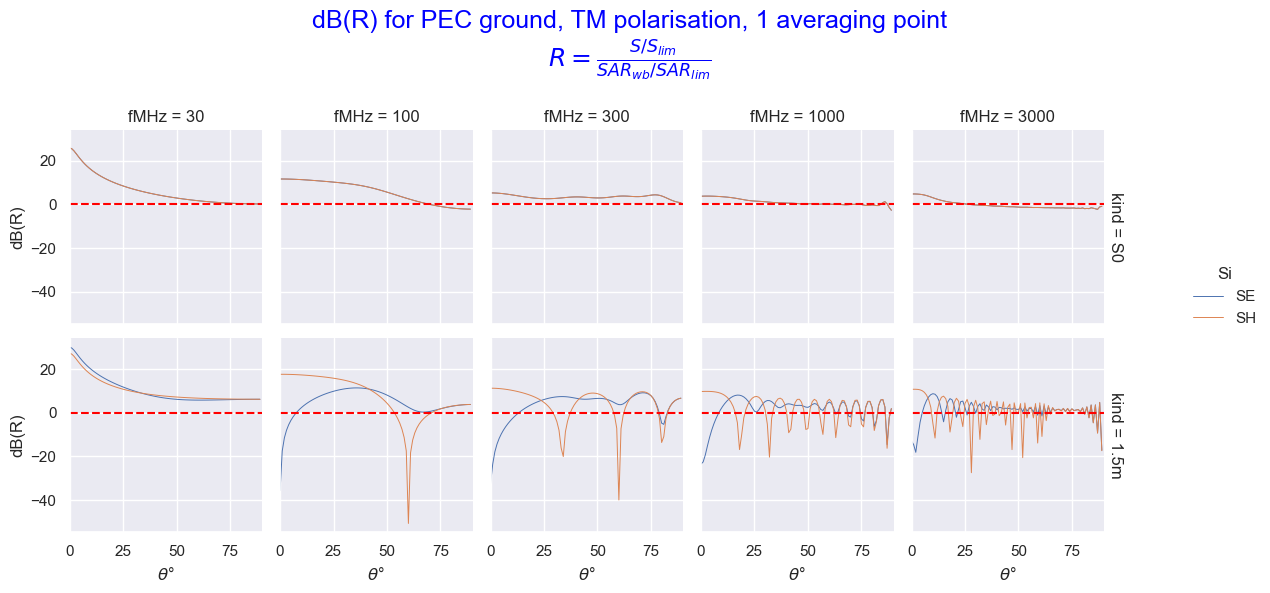

In [25]:
gnd = 'PEC'
pol = 'TM'
n = 1   # one of 1,3,5,7,13,19,121
freqs = [30,100,300,1000,3000]
df = Sall2
sns.set_theme(style="darkgrid")

dBRvTheta(df, gnd, pol, n)
for fe in ['png','svg']:
    plt.savefig(PLOTDIR + f'dBR v θ_{gnd}_{pol}_{n}pt.{fe}')

### err

#### line plots

In [53]:
def errvTheta(df, gnd, pol, n, kind="all"):
    # Filter the data
    mask = (df.gnd==gnd) & (df.pol==pol) & (df.n==n) & (df.fMHz.isin(freqs))
    if kind != "all":
        if isinstance(kind, str): kind = [kind] 
        mask = mask & (df.kind.isin(kind))

    # Plot the lines on two facets
    p = sns.relplot(
        df[mask],x="theta",y="dBerr",col="fMHz",row="kind",hue="Si",
        kind="line",linewidth=0.7,height=5, aspect=0.8,sort=False, 
        facet_kws=dict(margin_titles=True),
    )
    p.map(plt.axhline, y=0, ls='--', c='red')
    p.set(xlim=(0, 90),ylim=(-12,4),yticks=range(-12,6,2),xlabel=r'$\theta$°',ylabel='dB(err)')
    top = 0.78 if n==1 else 0.90
    p.fig.subplots_adjust(top=top)
    txt = f'point' if n==1 else 'points'
    p.fig.suptitle(f'dB(err) for {gnd} ground, {pol} polarisation, {n} averaging {txt}',color='blue',
                 fontsize=18)

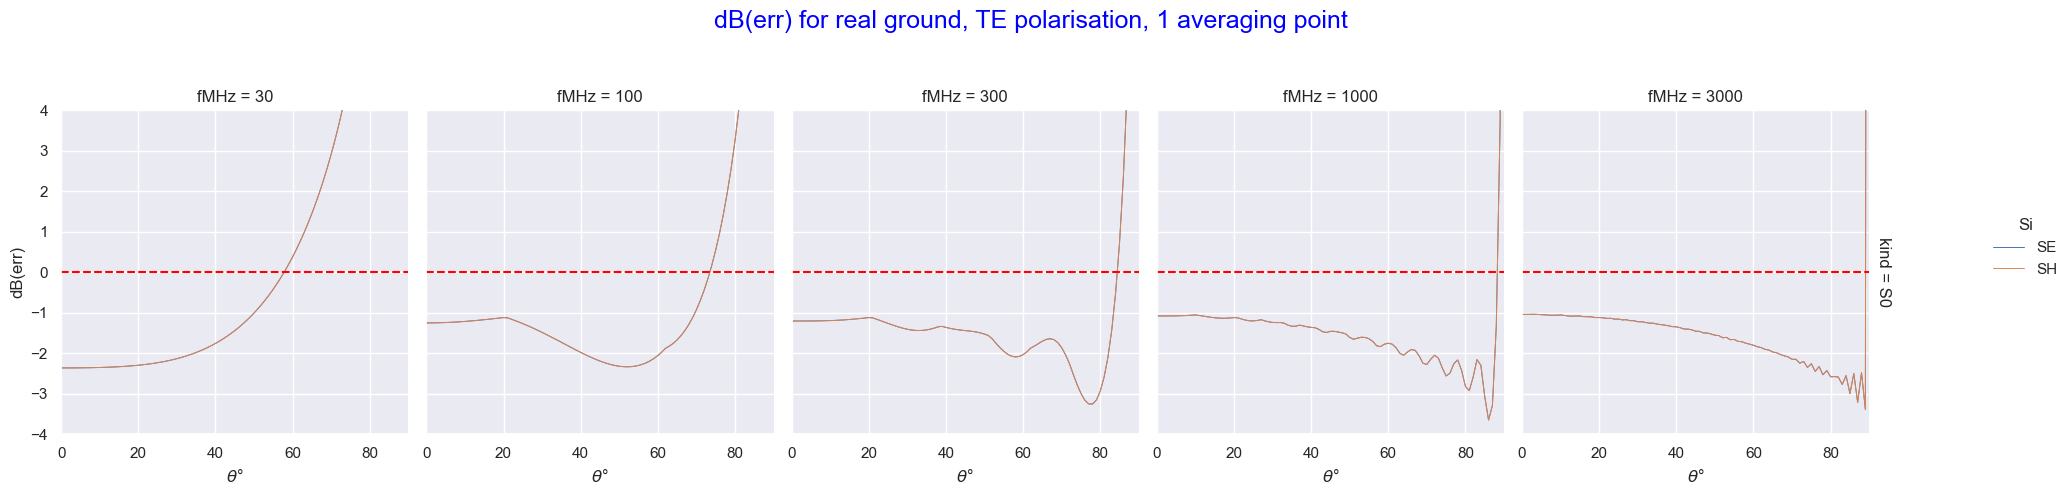

In [49]:
gnd = 'real'
pol = 'TE'
n = 1   # one of 1,3,5,7,13,19,121
freqs = [30,100,300,1000,3000]
df = Sall2
kind = "S0"
# kind = "all"
sns.set_theme(style="darkgrid")

errvTheta(df, gnd, pol, n, kind)
for fe in ['png','svg']:
    plt.savefig(PLOTDIR + f'dBerr v θ_{gnd}_{pol}_{n}pt.{fe}')

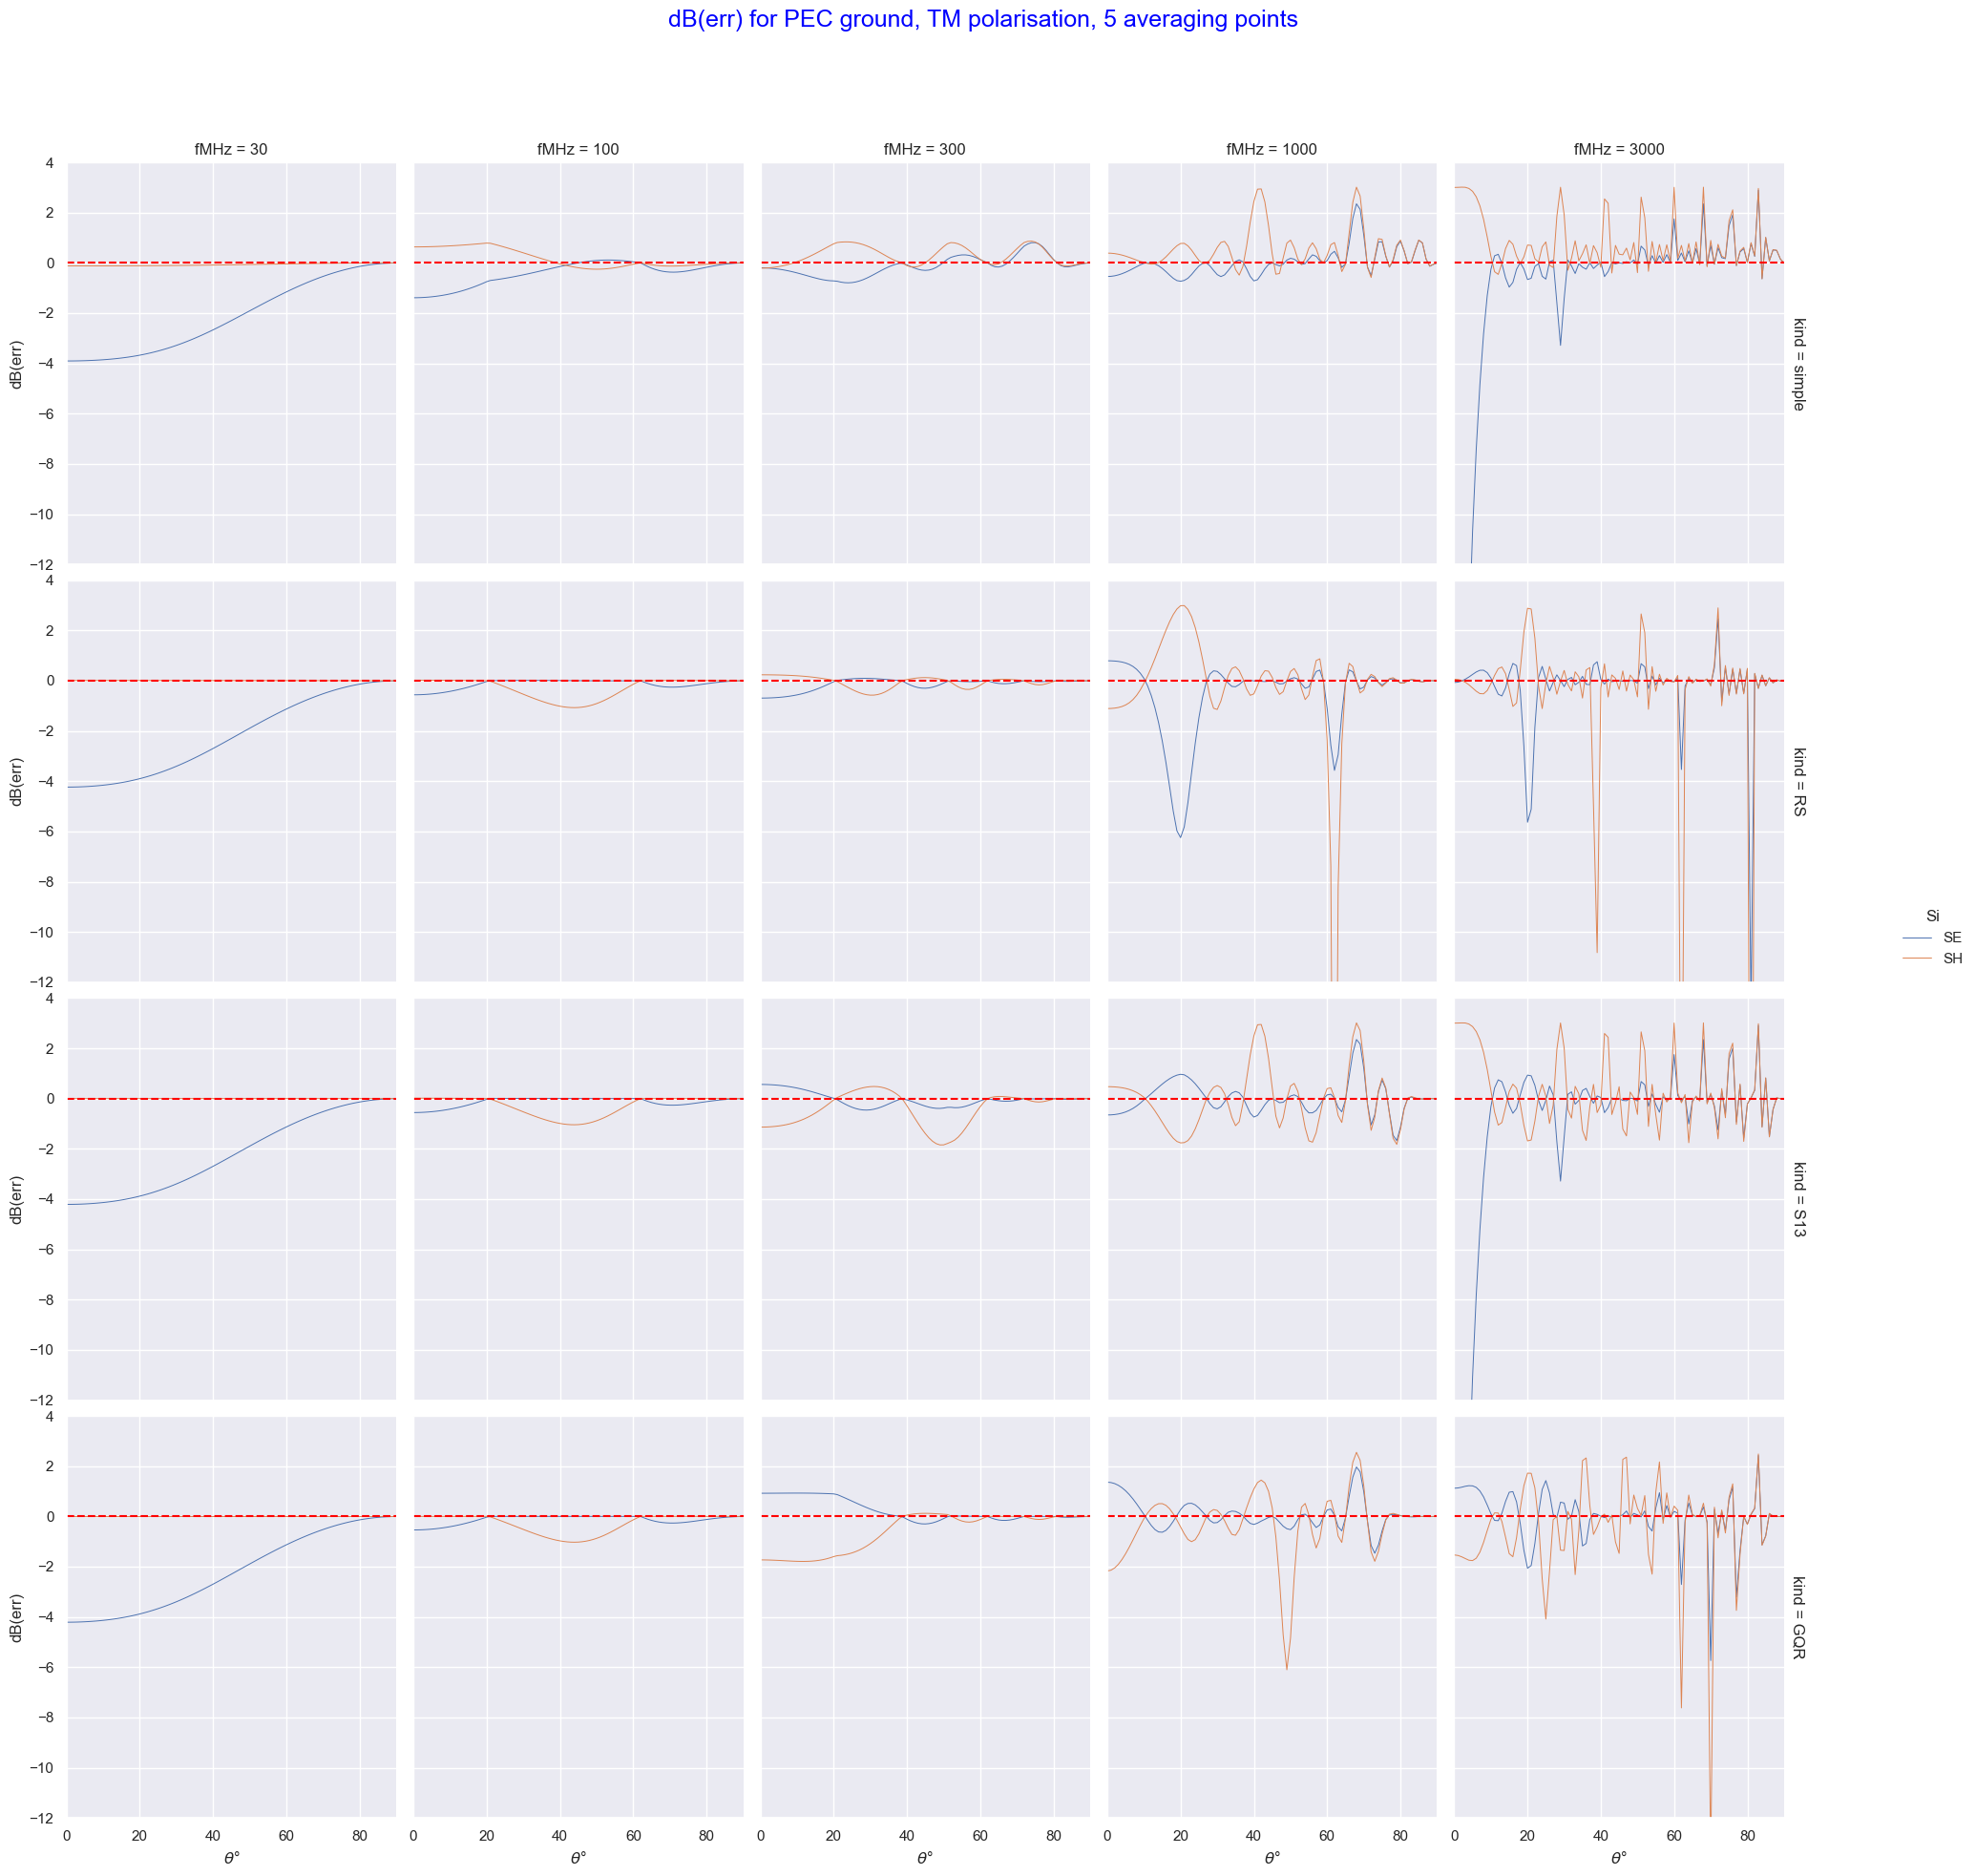

In [54]:
gnd = 'PEC'
pol = 'TM'
n = 5   # one of 1,3,5,7,13,19,121
freqs = [30,100,300,1000,3000]
df = Sall2
# kind = "S0"
kind = "all"
sns.set_theme(style="darkgrid")

errvTheta(df, gnd, pol, n, kind)
for fe in ['png','svg']:
    plt.savefig(PLOTDIR + f'dBerr v θ_{gnd}_{pol}_{n}pt.{fe}')

## PlaneEMR check

### PlaneEMR function

In [ ]:
def planeEMR(E0,z,zi,εr,σ,f,θ,pol):
    '''Calculates power density (SE = 0.5|E|²/Z0) for a E0 V/m plane wave
       travelling through a multilayered planar medium.
       The first and last layers have infinite thickness.
       Theory on which the algorithm is based can be found e.g. in Weng
       Cho Chew, "Waves and Fields in Inhomogeneous Media", IEEE PRESS
       Series on Electromagnetic Waves. This code was adapted from
       a Matlab script developed by Kimmo Karkkainen.
       
       INPUTS:
        E0 = E-field level of incident plane wave (V/m peak)
         z = list of z coords where |E|, SAR field levels are evaluated (m)
        zi = list of z coords for interfaces between multilayers (m)
        εr = list of relative permittivity for each layer
         σ = list of conductivity (S/m) for each layer
         f = frequency (Hz) of the planewave
         θ = incoming angle of the propagation vector (k)
             relative to the normal of the interface. 
       pol = polarization of the plane wave:
               'TM' = TM polarized wave (H parallel to interface)
               'TE' = TE polarized wave (E parallel to interface)

       OUTPUTS:       
          S Equivalent plane wave power density (SE = 0.5|E|²/Z0) at specified points (z)
'''

    # Set constants
    Z0 = 376.730313668           # free space impedance
    ε0 = 8.854187817620389e-12   # permittivity of free space
    µ0 = 1.2566370614359173e-06  # permeability of free space
    π = np.pi
    
    # Initialise variables    
    z = np.array(z).round(8)
    θ = θ * π / 180.   # convert θ from degrees to radians
    zi.append(1e9)     # add a very large z coord for 'infinite' last layer
    N = len(εr)        # N is the no. of layers
    w = 2. * π * f     # angular frequency 
    i = 1j             # i is imaginary unit
    
    # Wavenumber and its z-component in layers
    ε = [er*ε0 + s/(i*w) for er, s in zip(εr,σ)]
    K = [w*np.sqrt(e*µ0) for e in ε]
    Kz = [0]*N
    Kz[0] = K[0] * np.cos(θ)
    Kt    = K[0] * np.sin(θ)

    for L in range(1, N):
        SQ = K[L]**2 - Kt**2
        SQr = np.real(SQ)
        SQi = np.imag(SQ)
        if (SQi == 0) & (SQr < 0):
            Kz[L] = -np.sqrt(SQ)
        else:
            Kz[L] = np.sqrt(SQ)

    # Calculate reflection and transmission coefficients for interfaces
    R = np.zeros((N,N), dtype=complex)
    T = R.copy()
    for k in range(N-1):
        if pol == 'TM':
            # Reflection coefficient for magnetic field
            e1, e2 = ε[k+1] * Kz[k], ε[k] * Kz[k+1]
            R[k,k+1] = (e1 - e2) / (e1 + e2)
        elif pol == 'TE':
            # Reflection coefficient for electric field
            m1, m2 = µ0 * Kz[k],  µ0 * Kz[k+1]
            R[k,k+1] = (m1 - m2) / (m1 + m2)
        else:
            raise Exception(f'pol ({pol}) must be either TE or TM')

        R[k+1,k] = -R[k,k+1] 
        T[k,k+1] = 1 + R[k,k+1]
        T[k+1,k] = 1 + R[k+1,k]

    # Calculate generalized reflection coefficients for interfaces:
    gR = np.zeros(N, dtype=complex)
    for k in range(N-1)[::-1]:
        thickness = zi[k+1] - zi[k]  # layer thickness
        g = gR[k+1] * np.exp(-2*i*Kz[k+1] * thickness)
        gR[k] = (R[k,k+1] + g) / (1 + R[k,k+1] * g)

    A = np.zeros(N, dtype=complex)
    if pol == 'TM':
        A[0] = np.abs(K[0] / (w*µ0)) # Amplitude of magnetic field in layer 1
    else:
        A[0] = 1                        # Amplitude of electric field in layer 1

    # Calculate amplitudes in other layers:
    for k in range(1, N):
        A[k] = A[k-1] * np.exp(-i*Kz[k-1]*zi[k-1])*T[k-1,k] \
               /(1-R[k,k-1] * gR[k] * np.exp(-2*i*Kz[k]*(zi[k]-zi[k-1]))) \
               /np.exp(-i*Kz[k]*zi[k-1])

    # Form a vector that tells in which layer the calculation points are located:
    zl = []
    layer = 0
    for zp in z:
        while zp >= zi[layer]:
            layer += 1
        zl.append(layer)

    # Calculate E-field:
    Azl = np.array([A[z] for z in zl])
    Kzzl = np.array([Kz[z] for z in zl])
    gRzl = np.array([gR[z] for z in zl])
    εzl = np.array([ε[z] for z in zl])
    zizl = np.array([zi[z] for z in zl])
    σzl = np.array([σ[z] for z in zl])

    if pol == 'TM':
        # To be able to calculate electric field we have to differentiate
        # between forward and backward wave:
        Hf = Azl * np.exp(-i*Kzzl*z)
        Hb = Azl * gRzl * np.exp(-2*i*Kzzl*zizl + i*Kzzl*z)
        E1 = (Hf+Hb) / (w*εzl)*Kt
        E2 = (Hf-Hb) / (w*εzl)*Kzzl
        E = np.abs(np.sqrt(E1**2 + E2**2))
    else:
        # For TE wave electric field is simply:     
        E = np.abs(Azl*(np.exp(-i*Kzzl*z) + gRzl \
                   *np.exp(-2*i*Kzzl*zizl + i*Kzzl*z)));
    E = E0 * E

    # Calculate S (W/m²) at specified points z:
    S = 0.5 * E**2 / Z0
    
    return S

In [ ]:
def planeEMR_PEC(E0,z,εr,f,θ,pol):
    # Set constants
    Z0 = 376.730313668           # free space impedance
    ε0 = 8.854187817620389e-12   # permittivity of free space
    µ0 = 1.2566370614359173e-06  # permeability of free space
    π = np.pi
    
    # Initialise variables    
    z = np.array(z).round(8)
    θ = θ * π / 180.   # convert θ from degrees to radians
    # zi.append(1e9)     # add a very large z coord for 'infinite' last layer
    N = 1        # N is the no. of layers
    w = 2. * π * f     # angular frequency 
    i = 1j             # i is imaginary unit

    # Wavenumber and its z-component in layers
    ε = εr * ε0
    K = w*np.sqrt(ε*µ0)
    Kz = K * np.cos(θ)

    if pol == 'TM':
        # Calculate the total power flux density (incident + reflected) in TM
        S =  (2*E0**2/np.sqrt(µ0/ε))*np.sin(θ)*np.cos(Kz*z)**2
    elif pol == 'TE':
        # Calculate the total power flux density (incident + reflected) in TE
        S =  (2*E0**2/np.sqrt(µ0/ε))*np.sin(θ)*np.sin(Kz*z)**2
    else:
        raise Exception(f'pol ({pol}) must be either TE or TM')

    return S

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def planeEMRyong(E0,z,zi,εr,μr,σ,f,θ,pol):
    '''Calculates power density (SE = ½|E|²/Z0, SH = ½|H|²Z0) for a plane wave
       travelling through a multilayered infinite planar medium.
       The first and last layers have infinite thickness.
       Theory on which the algorithm is based can be found e.g. in Weng
       Cho Chew, "Waves and Fields in Inhomogeneous Media", IEEE PRESS
       Series on Electromagnetic Waves. This code was adapted from
       a Matlab script developed by Kimmo Karkkainen.
       
       INPUTS:
        E0 = E-field level of incident plane wave (V/m peak)
         z = list of z coords where |E|, SAR field levels are evaluated (m)
        zi = list of z coords for interfaces between planar layers (m)
        εr = list of relative permittivity for each layer
         σ = list of conductivity (S/m) for each layer
         f = frequency (Hz) of the planewave
         θ = incoming angle of the propagation vector (k)
             relative to the normal of the first interface. 
       pol = polarization of the plane wave:
               'TM' = TM polarized wave (H parallel to interface)
               'TE' = TE polarized wave (E parallel to interface)

       OUTPUTS:       
          SE = Equivalent plane wave power density (SE = ½|E|²/Z0) at specified points (z)
          SH = Equivalent plane wave power density (SE = ½Z0|H|²) at specified points (z)
'''

    # Set constants
    Z0 = 376.730313668           # free space impedance
    ε0 = 8.854187817620389e-12   # permittivity of free space
    µ0 = 1.2566370614359173e-06  # permeability of free space
    π = np.pi
    
    # Initialise variables    
    z = np.array(z).round(8)
    θ = θ * π / 180.   # convert θ from degrees to radians
    zi.append(1e9)     # add a very large z coord for 'infinite' last layer
    N = len(εr)        # N is the no. of layers
    w = 2. * π * f     # angular frequency 
    i = 1j             # i is imaginary unit
    
    # Wavenumber and its z-component in layers
    ε = [er*ε0 + s/(i*w) for er, s in zip(εr,σ)]
    μ = [ur*µ0 for ur in μr]
    K = [w*np.sqrt(e*µ0) for e in ε]
    Kz = [0]*N
    Kz[0] = K[0] * np.cos(θ)
    Kt    = K[0] * np.sin(θ)

    for L in range(1, N):
        SQ = K[L]**2 - Kt**2
        SQr = np.real(SQ)
        SQi = np.imag(SQ)
        if (SQi == 0) & (SQr < 0):
            Kz[L] = -np.sqrt(SQ)
        else:
            Kz[L] = np.sqrt(SQ)

    # Calculate reflection and transmission coefficients for interfaces
    R = np.zeros((N,N), dtype=complex)
    T = R.copy()
    for k in range(N-1):
        if pol == 'TM':
            # Reflection coefficient for magnetic field
            e1, e2 = ε[k+1] * Kz[k], ε[k] * Kz[k+1]
            R[k,k+1] = (e1 - e2) / (e1 + e2)
        elif pol == 'TE':
            # Reflection coefficient for electric field
            m1, m2 = μ[k+1] * Kz[k],  μ[k] * Kz[k+1]
            R[k,k+1] = (m1 - m2) / (m1 + m2)
        else:
            raise Exception(f'pol ({pol}) must be either TE or TM')

        R[k+1,k] = -R[k,k+1] 
        T[k,k+1] = 1 + R[k,k+1]
        T[k+1,k] = 1 + R[k+1,k]

    # Calculate generalized reflection coefficients for interfaces:
    gR = np.zeros(N, dtype=complex)
    for k in range(N-1)[::-1]:
        thickness = zi[k+1] - zi[k]  # layer thickness
        g = gR[k+1] * np.exp(-2*i*Kz[k+1] * thickness)
        gR[k] = (R[k,k+1] + g) / (1 + R[k,k+1] * g)

    A = np.zeros(N, dtype=complex)
    if pol == 'TM':
        A[0] = np.abs(K[0] / (w*μ[0]))  # Amplitude of magnetic field in layer 1
    else:
        A[0] = 1                        # Amplitude of electric field in layer 1

    # Calculate amplitudes in other layers:
    for k in range(1, N):
        A[k] = A[k-1] * np.exp(-i*Kz[k-1]*zi[k-1])*T[k-1,k] \
            /(1-R[k,k-1] * gR[k] * np.exp(-2*i*Kz[k]*(zi[k]-zi[k-1]))) \
            /np.exp(-i*Kz[k]*zi[k-1])

    # Form a vector that tells in which layer the calculation points are located:
    zl = []
    layer = 0
    for zp in z:
        while zp >= zi[layer]:
            layer += 1
        zl.append(layer)

    # Calculate E-field:
    Azl = np.array([A[z] for z in zl])
    Kzzl = np.array([Kz[z] for z in zl])
    Kzl = np.array([K[z] for z in zl])
    gRzl = np.array([gR[z] for z in zl])
    εzl = np.array([ε[z] for z in zl])
    zizl = np.array([zi[z] for z in zl])
    σzl = np.array([σ[z] for z in zl])

    if pol == 'TM':
        # The forward and backward Hf and Hb have only y component

        Hf = Azl * np.exp(-i*Kzzl*z)
        Hb = Azl * gRzl * np.exp(-2*i*Kzzl*zizl + i*Kzzl*z)
        Ex = Z0 * np.cos(θ) * (Hf-Hb)
        Ez = (-Z0) * np.sin(θ) * (Hf+Hb)
        Sh = 0.5 * E0 ** 2 * Z0 * (np.abs(Hf+Hb))**2
        Se = 0.5 * E0 ** 2 * (1/Z0) * (np.abs(Ex)**2 + np.abs(Ez)**2)

    else:
        # The forward and backward Ef and Eb have only y component
        Ef = Azl * np.exp(-i*Kzzl*z)
        Eb = Azl * gRzl * np.exp(-2*i*Kzzl*zizl + i*Kzzl*z)
        Hx = -(1/Z0) * np.cos(θ) * (Ef-Eb)
        Hz = (1/Z0) * np.sin(θ) * (Ef+Eb) 
        Sh = 0.5 * E0 ** 2 * Z0 * (np.abs(Hx)**2 + np.abs(Hz)**2)
        Se = 0.5 * E0 ** 2 * (1/Z0) * (np.abs(Ef+Eb))**2
        
    return Se, Sh

### Compare FEKO and planeEMR results

In [ ]:
def comparePEC(thetas,er,σ,f,pol):
    '''Compare FEKO, planeEMR & planeEMR_PEC results 
       for air/PEC two layer case'''
    
    E0 = 100
    z = np.linspace(-2,0,1001)
    fig, axes = plt.subplots(1,5, figsize=(10,6))
    
    for θ, ax in zip(thetas,axes):

        # Calculate planeEMR S levels
        zi = [0]
        S = planeEMR(E0,z,zi,er,σ,f,θ,pol)

        # Calculate planeEMR_PEC S levels
        Spec = planeEMR_PEC(E0,z,1,f,θ,pol)
        
        # Get FEKO S levels
        gnd = 'PEC'
        theta = θ
        fMHz = f / 1E6
        mask = (Sm.gnd==gnd) & (Sm.pol==pol) & (Sm.theta==theta) & \
               (Sm.fMHz==fMHz) & (Sm.z <= 2) & (Sm['S type']=='SE')
        df = Sm[mask]

        # Create plot
        ax.plot(df.S,df.z, '-', lw=3, alpha=0.5, label='FEKO')
        ax.plot(S,-z, '-', lw=1, label='planeEMR')
        ax.plot(Spec,-z, '--', lw=1, label='planeEMR_PEC')
        if θ==0: ax.set_ylabel('z (m)')
        ax.set_xlabel('S (W/m²)')
        ax.set_xlim(0, None)
        ax.set_ylim(0, 2.4)
        ax.set_xticks(range(0,80,20))
        ax.legend(fontsize=8)
        ax.grid(ls='--')
        ax.set_title(r'$\theta=$'+f'{theta}°')

    plt.suptitle(f'{fMHz:g} MHz, {gnd} ground, {pol},')    
    plt.tight_layout()

In [ ]:
def compareS(thetas,gnd,er,σ,f,pol,Stype):
    '''Compare FEKO, planeEMR & planeEMRyong results for two layer case'''
    
    E0 = 100
    zi = [0]
    z = np.linspace(-2,0,1001)
    fig, axes = plt.subplots(1,5, figsize=(10,6))
    
    for θ, ax in zip(thetas,axes):

        # Calculate planeEMR SE levels
        S = planeEMR(E0,z,zi,er,σ,f,θ,pol)

        # Calculate planeEMRyong SE levels
        μr = [1,1]
        Se, Sh = planeEMRyong(E0,z,zi,er,μr,σ,f,θ,pol)
        Syong = Se if Stype=='SE' else Sh

       # Get FEKO S levels
        theta = θ
        fMHz = f / 1E6
        mask = (Sm.gnd==gnd) & (Sm.pol==pol) & (Sm.theta==theta) & \
               (Sm.fMHz==fMHz) & (Sm.z <= 2) & (Sm['S type']==Stype)
        df = Sm[mask]
        
        # Calculate Yong's planeEMR levels
        εr = er
        μr = [1] * len(er)
        SE = planeEMRyong(E0,z,zi,εr,μr,σ,f,θ,pol)

        # Create plot
        ax.plot(df.S,df.z,'-',lw=4, alpha=0.5, label='FEKO',color='yellow')
        ax.plot(S,-z,'-',lw=1,label='planeEMR',color='red')
        ax.plot(Syong,-z,'--',lw=1,label='planeEMRYong',color='darkblue')
        
        if θ==0: ax.set_ylabel('z (m)')
        ax.set_xlabel('S (W/m²)')
        ax.set_xlim(0, 60)
        ax.set_ylim(0, 2.4)
        ax.legend(fontsize=8)
        ax.grid(ls='--')
        ax.set_title(r'$\theta=$'+f'{theta}°')

    plt.suptitle(f'{fMHz:g} MHz, {gnd} ground, {Stype}, {pol}')    
    plt.tight_layout()

In [17]:
# Compare FEKO with planeEMR and planeEMRyong for real groun for PEC ground
thetas = [0,30,45,60,89]
gnd = 'PEC'
er = [1, 1000]  # relative permittivity
σ = [0, 1E12]   # conductivity
f = 1.0E9       # 1 GHz
pol = 'TM'      # TM mode
Stype = 'SE'

compareS(thetas,gnd,er,σ,f,pol,Stype)

NameError: name 'compareS' is not defined

In [ ]:
# Compare FEKO with planeEMR and planeEMRyong for real groun for PEC ground
thetas = [0,30,45,60,89]
gnd = 'real'
er = [1, 10]  # relative permittivity
σ = [0, 0.001]   # conductivity
f = 1.0E9       # 1 GHz
pol = 'TE'      # TM mode
Stype = 'SH'

compareS(thetas,gnd,er,σ,f,pol,Stype)

In [ ]:
# Compare FEKO with planeEMR and Yong's planEMR_PEC
thetas = [0,30,45,60,89]
er = [1, 1000]  # relative permittivity
σ = [0, 1E12]   # conductivity
f = 1.0E9       # 1 GHz
pol = 'TM'      # TM mode

comparePEC(thetas,er,σ,f,pol)

## Scratch

In [23]:
def planeEMR(x,xi,er,sig,rho,f,angle,tm):
    '''Calculates |E| & SAR at for a 1 V/m plane wave
       travelling through a multilayered planar medium.
       The first and last layers have infinite thickness.
       Theory on which the algorithm is based can be found e.g. in Weng
       Cho Chew, "Waves and Fields in Inhomogeneous Media", IEEE PRESS
       Series on Electromagnetic Waves.
       
       INPUTS:
         x = points where |E|, SAR field levels are evaluated (m)
        xi = coordinates of interfaces between multilayers (m)
        er = relative permittivity
       sig = conductivity (S/m)
       rho = mass density (kg/m³)
         f = frequency (Hz) of the planewave
     angle = incoming angle of the propagation vector (k)
             relative to the normal of the interface. 
        tm = switch to select polarization of the plane wave:
               tm=1  TM polarized wave (H parallel to interface)
               tm=0  TE polarized wave (E parallel to interface)

       OUTPUTS:       
         SAR Specific Absorption Rate at specified points (x)
           E Magnitude of electric field value at specified points (x)
'''

    # Initialise variables
    x = array(x).round(8)
    angle = angle * pi/180.
    ε0 = 8.854187817620389e-12  # permittivity of free space
    mu0 = 1.2566370614359173e-06  # permeability of free space
    xi.append(1e9)                # add a large x coord for infinite last layer
    N = len(er)                   # N is the no. of layers (including air)
    w = 2. * pi * f               # angular frequency 
    i = 1j                        # i is imaginary unit
    
    # replace zeros in rho with a tiny number to avoid divide by zero error
    rho = [r if r!= 0 else 1e-9 for r in rho]

    # Wavenumber and its x-component in layers
    ε = [er*ε0 + s/(i*w) for er, s in zip(er,sig)]
    K = [w*sqrt(e*mu0) for e in ε]
    Kx = [0]*N
    Kx[0] = K[0] * cos(angle)
    Kt    = K[0] * sin(angle)

    for L in range(1, N):
        SQ = K[L]**2 - Kt**2
        SQr = real(SQ)
        SQi = imag(SQ)
        if (SQi == 0) & (SQr < 0):
            Kx[L] = -sqrt(SQ)
        else:
            Kx[L] = sqrt(SQ)

    # Calculate reflection and transmission coefficients for interfaces
    R = np.zeros((N,N), dtype=complex)
    T = R.copy()
    for k in range(N-1):
        if tm:
            # Reflection coefficient for magnetic field
            e1, e2 = ε[k+1] * Kx[k], ε[k] * Kx[k+1]
            R[k,k+1] = (e1 - e2) / (e1 + e2)
        else:
            # Reflection coefficient for electric field
            m1, m2 = mu0 * Kx[k],  mu0 * Kx[k+1]
            R[k,k+1] = (m1 - m2) / (m1 + m2)

        R[k+1,k] = -R[k,k+1] 
        T[k,k+1] = 1 + R[k,k+1]
        T[k+1,k] = 1 + R[k+1,k]

    # Calculate generalized reflection coefficients for interfaces:
    gR = np.zeros(N, dtype=complex)
    for k in range(N-1)[::-1]:
        thickness = xi[k+1] - xi[k]  # layer thickness
        g = gR[k+1] * exp(-2*i*Kx[k+1] * thickness)
        gR[k] = (R[k,k+1] + g) / (1 + R[k,k+1] * g)

    A = np.zeros(N, dtype=complex)
    if tm:
        A[0] = np.abs(K[0] / (w*mu0)) # Amplitude of magnetic field in layer 1
    else:
        A[0] = 1                        # Amplitude of electric field in layer 1

    # Calculate amplitudes in other layers:
    for k in range(1, N):
        A[k] = A[k-1] * exp(-i*Kx[k-1]*xi[k-1])*T[k-1,k] \
               /(1-R[k,k-1] * gR[k] * exp(-2*i*Kx[k]*(xi[k]-xi[k-1]))) \
               /exp(-i*Kx[k]*xi[k-1])

    # Form a vector that tells in which layer the calculation points are located:
    xl = []
    layer = 0
    for xp in x:
        while xp >= xi[layer]:
            layer += 1
        xl.append(layer)

    # Calculate field:
    Axl = np.array([A[x] for x in xl])
    Kxxl = np.array([Kx[x] for x in xl])
    gRxl = np.array([gR[x] for x in xl])
    εxl = np.array([ε[x] for x in xl])
    xixl = np.array([xi[x] for x in xl])
    sigxl = np.array([sig[x] for x in xl])
    rhoxl = np.array([rho[x] for x in xl])

    if tm:
        # To be able to calculate electric field we have to differentiate
        # between forward and backward wave:
        Hf = Axl * np.exp(-i*Kxxl*x)
        Hb = Axl * gRxl * np.exp(-2*i*Kxxl*xixl + i*Kxxl*x)
        E1 = (Hf+Hb) / (w*εxl)*Kt
        E2 = (Hf-Hb) / (w*εxl)*Kxxl
        E = np.abs(np.sqrt(E1**2 + E2**2))
    else:
        # For TE wave electric field is simply:     
        E = np.abs(Axl*(np.exp(-i*Kxxl*x) + gRxl \
                   *np.exp(-2*i*Kxxl*xixl + i*Kxxl*x)));

    # Calculate SAR (rms) in specified points x:
    SAR = sigxl * E**2 / rhoxl
    
    return E, SAR

,gnd,pol,fMHz,theta,z,S type,S
1641972,PEC,H,3000,2,0.001,SE,0.209194
1641973,PEC,H,3000,2,0.003,SE,1.862997
1641974,PEC,H,3000,2,0.005,SE,5.066672
1641975,PEC,H,3000,2,0.007,SE,9.618887
1641976,PEC,H,3000,2,0.009,SE,15.233563
...,...,...,...,...,...,...,...
3408227,PEC,H,3000,2,1.991,SH,38.339294
3408228,PEC,H,3000,2,1.993,SH,43.873145
3408229,PEC,H,3000,2,1.995,SH,48.319169
3408230,PEC,H,3000,2,1.997,SH,51.397960


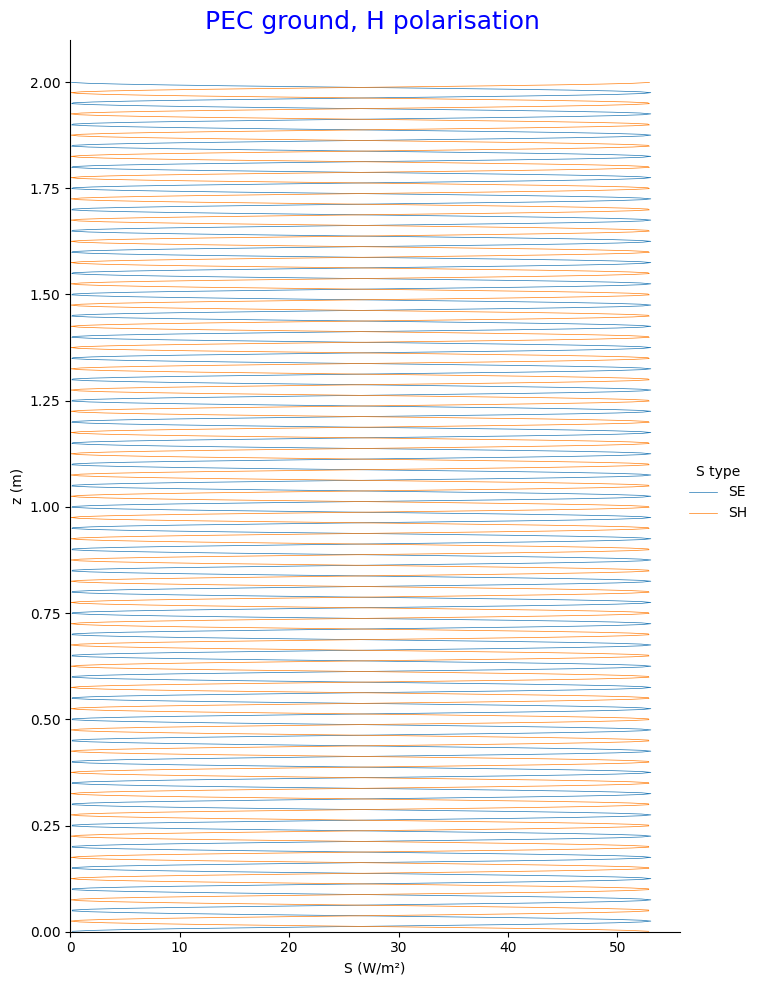

In [43]:
# View S over z
gnd = 'PEC'
pol = 'H'
theta = 2
fMHz = 3000
Si = 'SE'

mask = (Sm.gnd==gnd) & (Sm.pol==pol) & (Sm.theta==theta) & (Sm.fMHz==fMHz) & (Sm.z <= 2)
display(Sm[mask])

# Plot the lines on two facets
palette = sns.color_palette("rocket_r")
p = sns.relplot(data=Sm[mask],x="S", y="z",hue="S type",
                kind="line", linewidth=0.5,
                height=10, aspect=0.7, sort=False
)
p.set(xlim=(0, None),ylim=(0,None),xlabel='S (W/m²)',ylabel='z (m)')
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle(f'{gnd} ground, {pol} polarisation',color='blue',
             fontsize=18);

In [20]:
Ssa.gnd + '-' + Ssa.pol + 'pol-' + Ssa.fMHz.astype(str) + 'MHz-' + Ssa.Si + '-' + Ssa.L.astype(str) + 'm-' + Ssa.n.astype(str) + '-' + Ssa.kind 

0            PEC-Epol-30MHz-SE-1.6m-3-simple
1               PEC-Epol-30MHz-SE-1.6m-3-S13
2               PEC-Epol-30MHz-SE-1.6m-3-S38
3               PEC-Epol-30MHz-SE-1.6m-3-GQR
4            PEC-Epol-30MHz-SE-1.6m-5-simple
                        ...                 
61147        PEC-Hpol-3000MHz-SH-1.6m-19-GQR
61148    PEC-Hpol-3000MHz-SH-1.6m-121-simple
61149       PEC-Hpol-3000MHz-SH-1.6m-121-S13
61150       PEC-Hpol-3000MHz-SH-1.6m-121-S38
61151       PEC-Hpol-3000MHz-SH-1.6m-121-GQR
Length: 61152, dtype: object

In [35]:
# Spatial averaging functions          
          
def simple_avg(n, L):
    '''Simple average'''
    z = np.linspace(0,L,n)
    w = np.ones(n) / n
    return z, w

def GQR(n, L):
    '''Gaussian Legendre Quadrature Rule'''
    z, w = np.polynomial.legendre.leggauss(n)
    z = (z + 1) * L/2
    w = w / 2
    return z, w

def S13(n, L):
    '''Simpsons 1/3 Rule'''
    assert (n >= 2), f"n ({n}) must be >= 2"
    assert (n%2 == 1), f"n ({n}) must be odd"
    z = np.linspace(0,L,n)
    w = np.ones(n)
    wts = [4,2]*100  # a pop list for the weights

    for i in range(n-2):
        w[i+1] = wts.pop(0)
    w = w / sum(w)  
    return z, w

def S38(n, L):
    '''Simpsons 3/8 Rule'''
    assert (n >= 4), f"n ({n}) must be >= 4"
    assert ((n-1)%3 == 0), f"number of intervals ({n-1}) must be odd"
    z = np.linspace(0,L,n)
    w = np.ones(n)
    wts = [3,3,2]*100  # a pop list for the weights

    for i in range(n-2):
        w[i+1] = wts.pop(0)
    w = w / sum(w)  
    
    return z, w
    

In [13]:
gnd = 'PEC'
pol = 'E'
fMHz = 600
theta = 0
Si = 'SE'
kind = 'simple'
n = 241
L=1.6

mask = (S.gnd==gnd) & (S.pol==pol) & (S.fMHz==fMHz) & (S.theta==theta)
df = S[mask]
f = interpolate.interp1d(df.z.values, df[Si].values, kind='quadratic', fill_value='extrapolate')
# display(df[np.isclose(df.z,0,atol=0.001) | np.isclose(df.z,L,atol=0.001)].round(3))

def calcSsa(f, kind, n, L):
    z, w = sagnd(kind, n, L)
    Sz = f(z)
    Ssa = (Sz * w).sum()
    return Ssa

Ssa = [(kind,calcSsa(f,kind,n,L)) for kind in ('ps','simple','S13','S38','GQR')]
pd.DataFrame(Ssa,columns=('kind','Ssa'))    

,kind,Ssa
0,ps,48.410197
1,simple,26.145529
2,S13,26.152740
3,S38,26.152738
4,GQR,26.152742


In [37]:
z, w = sagnd('S13',9,L)
pd.DataFrame({'z':z,'w':w})

,z,w
0,0.0,0.041667
1,0.2,0.166667
2,0.4,0.083333
3,0.6,0.166667
4,0.8,0.083333
5,1.0,0.166667
6,1.2,0.083333
7,1.4,0.166667
8,1.6,0.041667


In [33]:
z, w = S13(9,L)
pd.DataFrame({'z':z,'w':w})

,z,w
0,0.0,0.041667
1,0.2,0.166667
2,0.4,0.083333
3,0.6,0.166667
4,0.8,0.083333
5,1.0,0.166667
6,1.2,0.083333
7,1.4,0.166667
8,1.6,0.041667


In [108]:
# Check FEKO .efe and .hfe input
gnd = 'PEC'
pol = 'E'
fileType = '.efe'

df = read_EH(gnd,pol,fileType)
mask = (t.z==2.001) & (t.theta==90)
df[mask]

./antennas/pw_gnd/PEC_Epol/PlaneWave_PEC_Epol.efe.zip


,gnd,pol,fMHz,theta,z,Exr,Exi,Eyr,Eyi,Ezr,Ezi
127090,PEC,E,30,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0
254581,PEC,E,60,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0
382072,PEC,E,100,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0
509563,PEC,E,300,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0
637054,PEC,E,600,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0
764545,PEC,E,1000,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0
892036,PEC,E,3000,90,2.001,0.0,0.0,0.0,0.0,200.0,0.0


In [6]:
mask = S.pol=='E'
S[mask]

,gnd,pol,fMHz,theta,x,y,z,SE,SH,Smax
0,PEC,E,30,0,0.0,0.0,0.001,0.000021,53.126357,53.126357
1,PEC,E,30,0,0.0,0.0,0.003,0.000189,53.126189,53.126189
2,PEC,E,30,0,0.0,0.0,0.005,0.000524,53.125853,53.125853
3,PEC,E,30,0,0.0,0.0,0.007,0.001028,53.125349,53.125349
4,PEC,E,30,0,0.0,0.0,0.009,0.001699,53.124677,53.124677
...,...,...,...,...,...,...,...,...,...,...
892432,PEC,E,3000,90,0.0,0.0,2.793,53.050398,53.126379,53.126379
892433,PEC,E,3000,90,0.0,0.0,2.795,53.050398,53.126379,53.126379
892434,PEC,E,3000,90,0.0,0.0,2.797,53.050398,53.126379,53.126379
892435,PEC,E,3000,90,0.0,0.0,2.799,53.050398,53.126379,53.126379


In [48]:
# Altair plot
gnd = 'PEC'
pol = 'H'
theta = 0
fMHz = 3000

mask = (S.gnd==gnd) & (S.pol==pol) & (S.theta==theta) & (S.fMHz==fMHz)
source = S[mask]
# source = source.iloc[::2,:]

brush = alt.selection_interval(resolve='global')

base = alt.Chart(source).mark_line().encode(
    x='z',
    color='fMHz:N'
).add_params(
    brush
).properties(
    width=250,
    height=250
# ).facet(
#     facet='fMHz:N',
#     columns=2
)
base.encode(y='SE') | base.encode(y='SH')


alt.HConcatChart(...)

In [131]:
# test readinf SAR file
folder = "./antennas/pw_gnd/PEC_Epol/"
file = "wbaSAR_30MHz.dat"
print(folder+SARfile)
pd.read_csv(folder+SARfile,skiprows=2,names=('theta','SARwb'),
            sep='\t',index_col=False)

./antennas/pw_gnd/PEC_Epol/wbaSAR_3000MHz.dat


,theta,SARwb
0,0.0,0.035383
1,1.0,0.035327
2,2.0,0.035480
3,3.0,0.035893
4,4.0,0.036641
5,5.0,0.037822
6,6.0,0.039544
7,7.0,0.041894
8,8.0,0.044911
9,9.0,0.048545
